In [1]:
# 로컬에서 오디오 라이브러리 쓰려면 처음에 설치해주어야 한다.
# pip install soundfile
# conda install -c conda-forge ffmpeg

In [2]:
# 공통 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path
from tqdm import tqdm

# 오디오 파일 라이브러리
import torchaudio
import IPython.display as ipd

# 딥러닝 라이브러리
import tensorflow as tf
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('CUDA:', torch.cuda.is_available(), '     Use << {} >>'.format(device.upper()))
print('PyTorch Version:', torch.__version__)

c:\Users\User\anaconda3\envs\s4pj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA: False      Use << CPU >>
PyTorch Version: 1.13.0+cpu


In [3]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
# pytorchtools 모듈에서 EarlyStopping 가져오기

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
SR = 16000
eps = 1e-6 # epsilon
DEV = 'cpu' # device
torch.set_printoptions(sci_mode=False) # 소수점 출력을 제한

In [5]:
# from google.colab import drive

# drive.mount('/content/drive')

In [6]:
# BASE_PATH = '/content/drive/MyDrive/데이터/s4pj/GTZAN Dataset - Music Genre Classification/genres_original/' # Colab
BASE_PATH = '../데이터/GTZAN Dataset - Music Genre Classification/genres_original/' # Window
# BASE_PATH = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/' # Kaggle

dir_path = Path(BASE_PATH)
audio_path_list = list(dir_path.rglob("*.wav"))
len(audio_path_list)

1000

In [7]:
# 샘플의 오디오를 들어보기 -> pop.00019.wav - Britney Spears "...Baby One More Time"

# pth = wave_paths[110] # Colab
pth = audio_path_list[719] # Window
# pth = wave_paths[935] # Kaggle

audio_sample, sr = torchaudio.load(pth)
ipd.Audio(audio_sample, rate=sr)

In [8]:
audio_sample

tensor([[-0.2120, -0.0675, -0.1841,  ..., -0.5098, -0.8558, -0.3735]])

In [9]:
audio_sample.shape, sr

(torch.Size([1, 661504]), 22050)

In [10]:
# 일반적으론 오디오 용량을 낮추기 위함 + 오디오 분류에서 높은 주파수 대역이 필요하지 않기 때문에 Resampling을 해준다.
# 그러나, Resampling한 데이터가 학습이 더 안 된다. 이유는 모름.

resampler = torchaudio.transforms.Resample(orig_freq = 22050, new_freq = SR)
audio_sample_ds = resampler(audio_sample)
ipd.Audio(audio_sample_ds, rate = SR), audio_sample_ds.shape

(<IPython.lib.display.Audio object>, torch.Size([1, 480003]))

In [11]:
# 스펙토그램 그려보기

spec_conveter = torchaudio.transforms.Spectrogram(n_fft = 1024)
db_conveter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_conveter(spec_conveter(audio_sample))
db_spec.shape

torch.Size([1, 513, 1293])

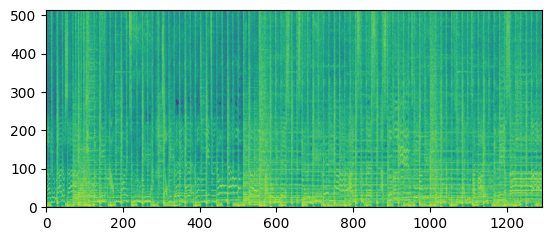

In [12]:
plt.imshow(db_spec[0], origin = 'lower')

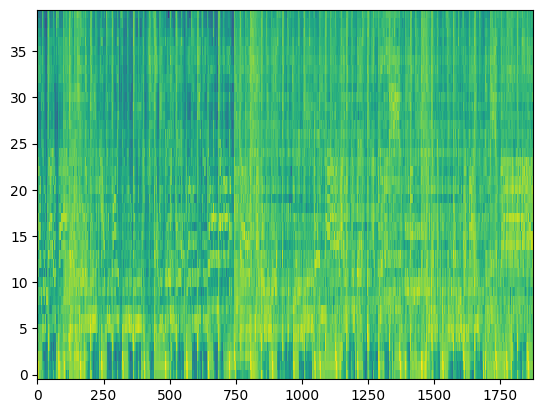

In [13]:
# mel_spectrogram 만들기

mel_spec_conveter = torchaudio.transforms.MelSpectrogram(sample_rate = SR, n_fft = 512, n_mels =40, f_max=6000)
mel_spec = mel_spec_conveter(audio_sample_ds)
plt.imshow(db_conveter(mel_spec[0]), origin = 'lower', aspect = 'auto', interpolation = 'nearest')

In [14]:
class Dataset:
  def __init__(self, dir_path, split ='train'):
    self.dir_path = Path(dir_path)
    self.wave_ps = list(self.dir_path.rglob("*.wav")) #genrator -> list
    self.wave_pths = []
    # batch 를 지정해서 만들다가, jazz.00054 파일에 에러가 떴다. 그래서 00054는 예외처리를 해주었다.
    for i in self.wave_ps:
      if i.stem == 'jazz.00054':
        pass
      else:
        self.wave_pths.append(i)

  
    splitted_pths = []
    for pth in self.wave_pths:
      if split =='train' and int(pth.stem.split('.')[1])<60:  # stem : Path 라이브러리의 함수. 파일 경로의 파일 이름을 추출해준다.
          splitted_pths.append(pth)
      elif split =='valid' and 60<= int(pth.stem.split('.')[1])<80:
          splitted_pths.append(pth)
      elif split =='test' and int(pth.stem.split('.')[1])>=80:
          splitted_pths.append(pth)
    self.wave_pths = splitted_pths

    # Genre indexing
    self.genre_names = list(set([x.stem.split('.')[0] for x in self.wave_pths]))
    self.genre_names.sort()
    self.str2idx = {string:idx for idx, string in enumerate (self.genre_names)}
  def __len__(self):
      return len(self.wave_pths)

  def __getitem__(self, idx): #idx -> input parameter
    pth = self.wave_pths[idx]
    audio_sample, sr = torchaudio.load(pth)

    genre_str = pth.stem.split('.')[0]
    #29초로 모두 동일화
    # 어떤건 30.1초, 30.2초 등등, 즉 오디오 샘플 size가 다르기 때문
    # 따라서, 모든 샘플의 행렬의 크기가 동일하지 않아 후에 에러가 난다.

    return audio_sample[0,:sr*29], self.str2idx[genre_str]
    

In [15]:
trainset = Dataset(dir_path)
validset = Dataset(dir_path, split= 'valid')
testset = Dataset(dir_path, split= 'test')
print(len(trainset), len(validset), len(testset))
print(trainset[0])

599 200 200
(tensor([ 0.0073,  0.0166,  0.0076,  ..., -0.1567, -0.1489, -0.1308]), 0)


In [16]:
train_loader = DataLoader(trainset, batch_size = 32, shuffle= True)
valid_loader = DataLoader(trainset, batch_size = 128, shuffle= False)
test_loader = DataLoader(trainset, batch_size = 128, shuffle= False)

In [17]:
for X, y in train_loader:
  print('Shape of X :\n', X.shape)
  print('Shape of y :\n', y.shape, '\n', y.dtype)
  break

Shape of X :
 torch.Size([32, 639450])
Shape of y :
 torch.Size([32]) 
 torch.int64


In [ ]:
# 손실 함수 만들기

def NLLLoss(pred, target, eps = 1e-6):
  pred_value_for_correct_class = pred[torch.arange(len(target)), target]
  nll_value = -torch.log(pred_value_for_correct_class + eps)
  
  return torch.mean(nll_value)

In [ ]:
# 훈련 함수 만들기

def train(dataloader, model, optimizer):
    pbar = tqdm(dataloader, desc=f'Training')
    for batch, (X, y) in enumerate(pbar):
        X, y = X.to(device), y.to(device)
 
        # Feedforward
        pred = model(X)
 
        # Calc. Loss
        loss = NLLLoss(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# 테스트 함수 만들기

def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += NLLLoss(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size

    if dataloader == valid_loader :
        print(f'Validation Accuracy: {(100*correct):>0.1f}%     Loss: {loss:>8f} \n')
    elif dataloader == test_loader :
        print(f'Test Accuracy: {(100*correct):>0.1f}%     Loss: {loss:>8f} \n')
 
    return 100*correct, loss

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.num_frame = 30
    self.n_mels = 40
    
    self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    
    self.nn_layer = nn.Sequential(
                    nn.Linear(self.n_mels*self.num_frame, 512), # input layer. take input and return hidden representation
                    nn.ReLU(),
                    nn.Dropout(0.2),

                    nn.Linear(512, 256), # hidden layer. 
                    nn.ReLU(),
                    nn.Dropout(0.2),

                    nn.Linear(256, 128), # hidden layer. 
                    nn.ReLU(),
                    nn.Dropout(0.2),

                    nn.Linear(128, 64), # hidden layer. 
                    nn.ReLU(),
                    nn.Dropout(0.2),

                    nn.Linear(64, 10),  # output layer 
                    nn.Softmax(dim=-1)
    )
    
  def forward(self, x):
    spec = self.mel_spec_converter(x)
    db_spec = self.db_converter(spec)
    sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
    sliced_spec = sliced_spec.reshape(x.shape[0], -1) # -1은 남는 디멘션을 자동으로 계산. 전체 element가 3200이고 0번째 dim 8이면 남은 1번째 디멘션은 자동으로 400

    out = self.nn_layer(sliced_spec)
    
    return out

----- Epoch 1 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


Validation Accuracy: 25.0%     Loss: 2.139895 

Validation loss decreased (inf --> 2.139895).  Saving model ...
----- Epoch 2 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Validation Accuracy: 30.1%     Loss: 1.918668 

Validation loss decreased (2.139895 --> 1.918668).  Saving model ...
----- Epoch 3 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Validation Accuracy: 33.9%     Loss: 1.864332 

Validation loss decreased (1.918668 --> 1.864332).  Saving model ...
----- Epoch 4 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]


Validation Accuracy: 37.9%     Loss: 1.741754 

Validation loss decreased (1.864332 --> 1.741754).  Saving model ...
----- Epoch 5 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]


Validation Accuracy: 38.9%     Loss: 1.637289 

Validation loss decreased (1.741754 --> 1.637289).  Saving model ...
----- Epoch 6 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


Validation Accuracy: 46.1%     Loss: 1.503280 

Validation loss decreased (1.637289 --> 1.503280).  Saving model ...
----- Epoch 7 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]


Validation Accuracy: 50.9%     Loss: 1.388907 

Validation loss decreased (1.503280 --> 1.388907).  Saving model ...
----- Epoch 8 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Validation Accuracy: 54.6%     Loss: 1.324542 

Validation loss decreased (1.388907 --> 1.324542).  Saving model ...
----- Epoch 9 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Validation Accuracy: 52.9%     Loss: 1.285418 

Validation loss decreased (1.324542 --> 1.285418).  Saving model ...
----- Epoch 10 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


Validation Accuracy: 60.9%     Loss: 1.115721 

Validation loss decreased (1.285418 --> 1.115721).  Saving model ...
----- Epoch 11 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


Validation Accuracy: 71.5%     Loss: 0.891998 

Validation loss decreased (1.115721 --> 0.891998).  Saving model ...
----- Epoch 12 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Validation Accuracy: 63.4%     Loss: 0.951485 

EarlyStopping counter: 1 out of 3
----- Epoch 13 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Validation Accuracy: 69.8%     Loss: 0.989104 

EarlyStopping counter: 2 out of 3
----- Epoch 14 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Validation Accuracy: 78.5%     Loss: 0.751044 

Validation loss decreased (0.891998 --> 0.751044).  Saving model ...
----- Epoch 15 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


Validation Accuracy: 75.3%     Loss: 0.705731 

Validation loss decreased (0.751044 --> 0.705731).  Saving model ...
----- Epoch 16 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


Validation Accuracy: 82.1%     Loss: 0.554472 

Validation loss decreased (0.705731 --> 0.554472).  Saving model ...
----- Epoch 17 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


Validation Accuracy: 87.6%     Loss: 0.403524 

Validation loss decreased (0.554472 --> 0.403524).  Saving model ...
----- Epoch 18 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]


Validation Accuracy: 82.5%     Loss: 0.476518 

EarlyStopping counter: 1 out of 3
----- Epoch 19 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Validation Accuracy: 86.0%     Loss: 0.449268 

EarlyStopping counter: 2 out of 3
----- Epoch 20 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]


Validation Accuracy: 79.5%     Loss: 0.567921 

EarlyStopping counter: 3 out of 3


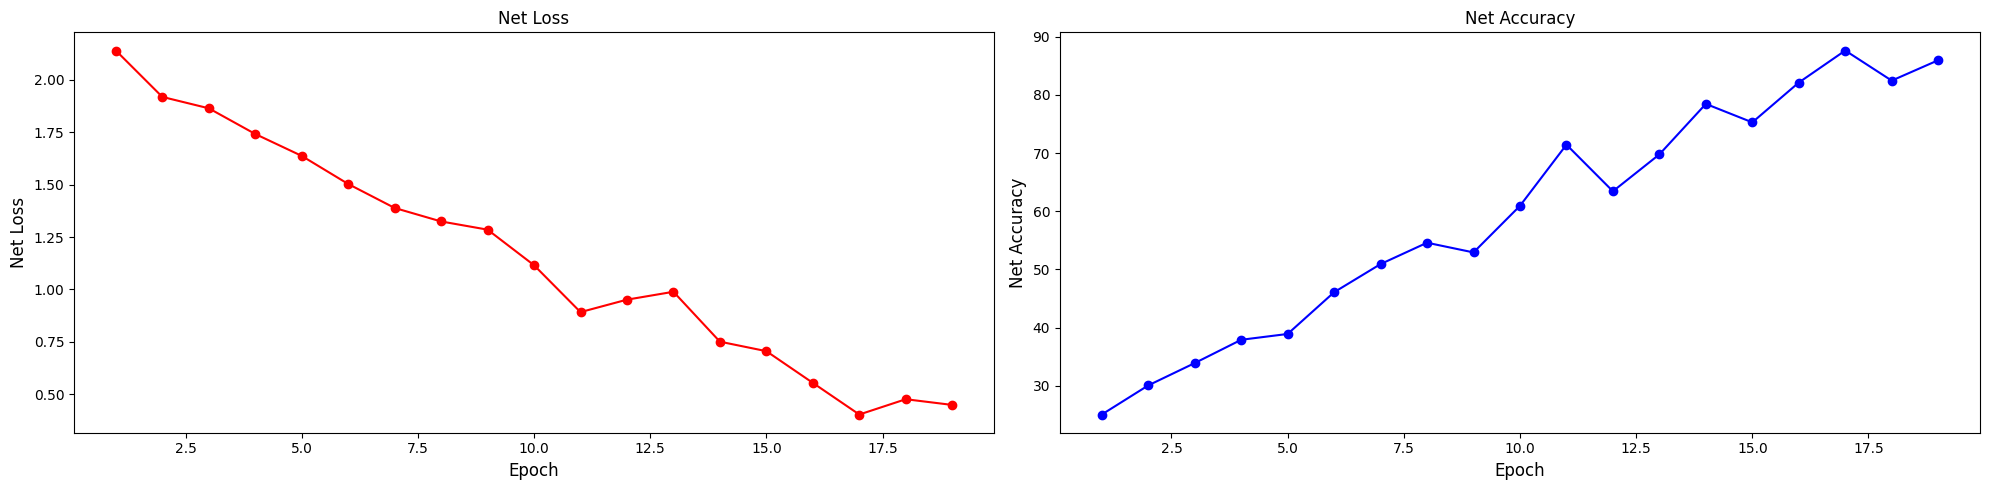

In [ ]:
# Run the Training and Evaluation
# first model => Net

model_1 = Net().to(device)
opt = optim.Adam(model_1.parameters(), lr = 1e-3)
early_stopping = EarlyStopping(patience = 3, verbose = True, path='Net.pt')

# Plot
fig = plt.figure(figsize=(20,5))
line1, line2 = plt.plot([],[],[],[])
plt.clf()

# Train the Network
epochs = 50

for t in range(epochs):
    print(f'----- Epoch {t+1} -----')
    train(train_loader, model_1, opt)
    accuracy, loss = test(valid_loader, model_1)

    early_stopping(loss, model_1)

    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
 
    # Add Accuracy & Loss to the Lines
    line1.set_xdata(np.append(line1.get_xdata(), t+1))
    line1.set_ydata(np.append(line1.get_ydata(), loss))
    line2.set_ydata(np.append(line2.get_ydata(), accuracy))

fig.add_subplot(1,2,1)
plt.title('Net Loss')
plt.plot(line1.get_xdata(), line1.get_ydata(), color='red')
plt.plot(line1.get_xdata(), line1.get_ydata(), 'o', color='red')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('Net Loss', fontsize=12)
fig.add_subplot(1,2,2)
plt.title('Net Accuracy')
plt.plot(line1.get_xdata(), line2.get_ydata(), color='blue')
plt.plot(line1.get_xdata(), line2.get_ydata(), 'o', color='blue')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('Net Accuracy', fontsize=12)
 
plt.tight_layout()
plt.autoscale()
plt.show()

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.num_frame = 30
    self.n_mels = 40
    
    self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    
    self.nn_layer = nn.Sequential(
                    nn.Linear(self.n_mels*self.num_frame, 128), # input layer. take input and return hidden representation
                    nn.ReLU(),

                    nn.Linear(128, 64), # hidden layer. 
                    nn.ReLU(),
                    
                    nn.Linear(64, 10),  # output layer
                    nn.Softmax(dim=-1)
    )
    
  def forward(self, x):
    spec = self.mel_spec_converter(x)
    db_spec = self.db_converter(spec)
    sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
    sliced_spec = sliced_spec.reshape(x.shape[0], -1) # -1은 남는 디멘션을 자동으로 계산. 전체 element가 3200이고 0번째 dim 8이면 남은 1번째 디멘션은 자동으로 400

    out = self.nn_layer(sliced_spec)
    
    return out

----- Epoch 1 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]


Validation Accuracy: 29.0%     Loss: 2.063704 

Validation loss decreased (inf --> 2.063704).  Saving model ...
----- Epoch 2 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Validation Accuracy: 38.6%     Loss: 1.786197 

Validation loss decreased (2.063704 --> 1.786197).  Saving model ...
----- Epoch 3 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


Validation Accuracy: 50.4%     Loss: 1.465034 

Validation loss decreased (1.786197 --> 1.465034).  Saving model ...
----- Epoch 4 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]


Validation Accuracy: 52.9%     Loss: 1.357320 

Validation loss decreased (1.465034 --> 1.357320).  Saving model ...
----- Epoch 5 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]


Validation Accuracy: 51.1%     Loss: 1.411246 

EarlyStopping counter: 1 out of 3
----- Epoch 6 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


Validation Accuracy: 55.9%     Loss: 1.308172 

Validation loss decreased (1.357320 --> 1.308172).  Saving model ...
----- Epoch 7 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


Validation Accuracy: 55.4%     Loss: 1.323420 

EarlyStopping counter: 1 out of 3
----- Epoch 8 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


Validation Accuracy: 65.9%     Loss: 1.093203 

Validation loss decreased (1.308172 --> 1.093203).  Saving model ...
----- Epoch 9 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


Validation Accuracy: 71.3%     Loss: 0.909661 

Validation loss decreased (1.093203 --> 0.909661).  Saving model ...
----- Epoch 10 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]


Validation Accuracy: 64.6%     Loss: 1.045593 

EarlyStopping counter: 1 out of 3
----- Epoch 11 -----


Training: 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]


Validation Accuracy: 77.6%     Loss: 0.775127 

Validation loss decreased (0.909661 --> 0.775127).  Saving model ...
----- Epoch 12 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Validation Accuracy: 83.5%     Loss: 0.607464 

Validation loss decreased (0.775127 --> 0.607464).  Saving model ...
----- Epoch 13 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Validation Accuracy: 80.8%     Loss: 0.642383 

EarlyStopping counter: 1 out of 3
----- Epoch 14 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]


Validation Accuracy: 86.6%     Loss: 0.532628 

Validation loss decreased (0.607464 --> 0.532628).  Saving model ...
----- Epoch 15 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]


Validation Accuracy: 80.6%     Loss: 0.614840 

EarlyStopping counter: 1 out of 3
----- Epoch 16 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]


Validation Accuracy: 88.0%     Loss: 0.417596 

Validation loss decreased (0.532628 --> 0.417596).  Saving model ...
----- Epoch 17 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]


Validation Accuracy: 91.8%     Loss: 0.348123 

Validation loss decreased (0.417596 --> 0.348123).  Saving model ...
----- Epoch 18 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]


Validation Accuracy: 88.8%     Loss: 0.343044 

Validation loss decreased (0.348123 --> 0.343044).  Saving model ...
----- Epoch 19 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


Validation Accuracy: 91.0%     Loss: 0.340589 

Validation loss decreased (0.343044 --> 0.340589).  Saving model ...
----- Epoch 20 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


Validation Accuracy: 93.3%     Loss: 0.262094 

Validation loss decreased (0.340589 --> 0.262094).  Saving model ...
----- Epoch 21 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


Validation Accuracy: 95.2%     Loss: 0.244327 

Validation loss decreased (0.262094 --> 0.244327).  Saving model ...
----- Epoch 22 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]


Validation Accuracy: 92.5%     Loss: 0.262033 

EarlyStopping counter: 1 out of 3
----- Epoch 23 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]


Validation Accuracy: 92.7%     Loss: 0.265648 

EarlyStopping counter: 2 out of 3
----- Epoch 24 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


Validation Accuracy: 96.2%     Loss: 0.181446 

Validation loss decreased (0.244327 --> 0.181446).  Saving model ...
----- Epoch 25 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]


Validation Accuracy: 91.0%     Loss: 0.289418 

EarlyStopping counter: 1 out of 3
----- Epoch 26 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]


Validation Accuracy: 96.7%     Loss: 0.148198 

Validation loss decreased (0.181446 --> 0.148198).  Saving model ...
----- Epoch 27 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]


Validation Accuracy: 94.5%     Loss: 0.170091 

EarlyStopping counter: 1 out of 3
----- Epoch 28 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Validation Accuracy: 97.0%     Loss: 0.125771 

Validation loss decreased (0.148198 --> 0.125771).  Saving model ...
----- Epoch 29 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


Validation Accuracy: 99.2%     Loss: 0.081040 

Validation loss decreased (0.125771 --> 0.081040).  Saving model ...
----- Epoch 30 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


Validation Accuracy: 98.7%     Loss: 0.078573 

Validation loss decreased (0.081040 --> 0.078573).  Saving model ...
----- Epoch 31 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


Validation Accuracy: 99.5%     Loss: 0.056842 

Validation loss decreased (0.078573 --> 0.056842).  Saving model ...
----- Epoch 32 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]


Validation Accuracy: 99.0%     Loss: 0.069963 

EarlyStopping counter: 1 out of 3
----- Epoch 33 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]


Validation Accuracy: 98.0%     Loss: 0.080608 

EarlyStopping counter: 2 out of 3
----- Epoch 34 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Validation Accuracy: 99.7%     Loss: 0.052286 

Validation loss decreased (0.056842 --> 0.052286).  Saving model ...
----- Epoch 35 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]


Validation Accuracy: 99.8%     Loss: 0.031192 

Validation loss decreased (0.052286 --> 0.031192).  Saving model ...
----- Epoch 36 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


Validation Accuracy: 99.8%     Loss: 0.027183 

Validation loss decreased (0.031192 --> 0.027183).  Saving model ...
----- Epoch 37 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Validation Accuracy: 99.8%     Loss: 0.017931 

Validation loss decreased (0.027183 --> 0.017931).  Saving model ...
----- Epoch 38 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Validation Accuracy: 99.8%     Loss: 0.015696 

Validation loss decreased (0.017931 --> 0.015696).  Saving model ...
----- Epoch 39 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]


Validation Accuracy: 99.7%     Loss: 0.025723 

EarlyStopping counter: 1 out of 3
----- Epoch 40 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]


Validation Accuracy: 98.5%     Loss: 0.057489 

EarlyStopping counter: 2 out of 3
----- Epoch 41 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]


Validation Accuracy: 93.3%     Loss: 0.273892 

EarlyStopping counter: 3 out of 3


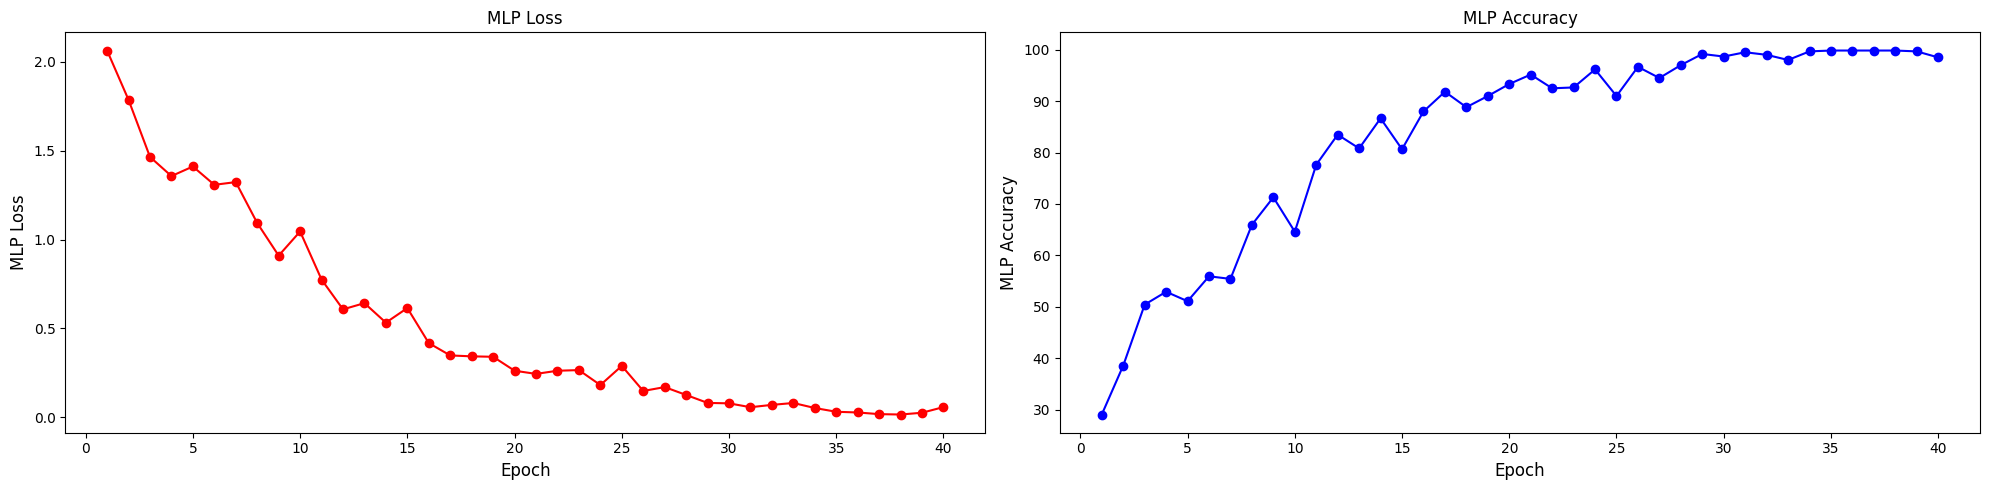

In [ ]:
# Run the Training and Evaluation
# second model => MLP

model_2 = MLP().to(device)
opt = optim.Adam(model_2.parameters(), lr = 1e-3)
early_stopping = EarlyStopping(patience = 3, verbose = True, path='MLP_1.pt')

# Plot
fig = plt.figure(figsize=(20,5))
line1, line2 = plt.plot([],[],[],[])
plt.clf()

# Train the Network
epochs = 50

for t in range(epochs):
    print(f'----- Epoch {t+1} -----')
    train(train_loader, model_2, opt)
    accuracy, loss = test(valid_loader, model_2)

    early_stopping(loss, model_2)

    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
 
    # Add Accuracy & Loss to the Lines
    line1.set_xdata(np.append(line1.get_xdata(), t+1))
    line1.set_ydata(np.append(line1.get_ydata(), loss))
    line2.set_ydata(np.append(line2.get_ydata(), accuracy))

fig.add_subplot(1,2,1)
plt.title('MLP Loss')
plt.plot(line1.get_xdata(), line1.get_ydata(), color='red')
plt.plot(line1.get_xdata(), line1.get_ydata(), 'o', color='red')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('MLP Loss', fontsize=12)
fig.add_subplot(1,2,2)
plt.title('MLP Accuracy')
plt.plot(line1.get_xdata(), line2.get_ydata(), color='blue')
plt.plot(line1.get_xdata(), line2.get_ydata(), 'o', color='blue')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('MLP Accuracy', fontsize=12)
 
plt.tight_layout()
plt.autoscale()
plt.show()

In [ ]:
class LSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, dropout=0, bidirectional=False):
    super(LSTM, self).__init__()
    self.num_frame = 30
    self.n_mels = 40
    
    self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    input_size = self.n_mels*self.num_frame

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_direction = int(bidirectional) + 1
    self.rnn = nn.LSTM(input_size, hidden_size, 1, dropout=dropout, batch_first=True, bidirectional=bidirectional)

    
  def forward(self, x):
    spec = self.mel_spec_converter(x)
    db_spec = self.db_converter(spec)

    sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
    sliced_spec = sliced_spec.reshape(x.shape[0], -1)

    out = sliced_spec

    rnn_output, _ = self.rnn(out)
    
    return torch.softmax(rnn_output, dim=-1)

----- Epoch 1 -----


Training: 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]


Validation Accuracy: 15.9%     Loss: 4.345299 

Validation loss decreased (inf --> 4.345299).  Saving model ...
----- Epoch 2 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Validation Accuracy: 13.4%     Loss: 4.121944 

Validation loss decreased (4.345299 --> 4.121944).  Saving model ...
----- Epoch 3 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Validation Accuracy: 13.5%     Loss: 3.934884 

Validation loss decreased (4.121944 --> 3.934884).  Saving model ...
----- Epoch 4 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


Validation Accuracy: 15.7%     Loss: 3.869065 

Validation loss decreased (3.934884 --> 3.869065).  Saving model ...
----- Epoch 5 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Validation Accuracy: 15.0%     Loss: 3.826168 

Validation loss decreased (3.869065 --> 3.826168).  Saving model ...
----- Epoch 6 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Validation Accuracy: 15.4%     Loss: 3.812166 

Validation loss decreased (3.826168 --> 3.812166).  Saving model ...
----- Epoch 7 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


Validation Accuracy: 15.7%     Loss: 3.789872 

Validation loss decreased (3.812166 --> 3.789872).  Saving model ...
----- Epoch 8 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Validation Accuracy: 15.7%     Loss: 3.778088 

Validation loss decreased (3.789872 --> 3.778088).  Saving model ...
----- Epoch 9 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Validation Accuracy: 17.2%     Loss: 3.765355 

Validation loss decreased (3.778088 --> 3.765355).  Saving model ...
----- Epoch 10 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Validation Accuracy: 17.9%     Loss: 3.751254 

Validation loss decreased (3.765355 --> 3.751254).  Saving model ...
----- Epoch 11 -----


Training: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


Validation Accuracy: 16.5%     Loss: 3.749469 

Validation loss decreased (3.751254 --> 3.749469).  Saving model ...
----- Epoch 12 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Validation Accuracy: 16.9%     Loss: 3.765353 

EarlyStopping counter: 1 out of 3
----- Epoch 13 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


Validation Accuracy: 19.5%     Loss: 3.756767 

EarlyStopping counter: 2 out of 3
----- Epoch 14 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Validation Accuracy: 19.7%     Loss: 3.735407 

Validation loss decreased (3.749469 --> 3.735407).  Saving model ...
----- Epoch 15 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Validation Accuracy: 20.0%     Loss: 3.735259 

Validation loss decreased (3.735407 --> 3.735259).  Saving model ...
----- Epoch 16 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Validation Accuracy: 20.9%     Loss: 3.730863 

Validation loss decreased (3.735259 --> 3.730863).  Saving model ...
----- Epoch 17 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Validation Accuracy: 20.9%     Loss: 3.722126 

Validation loss decreased (3.730863 --> 3.722126).  Saving model ...
----- Epoch 18 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Validation Accuracy: 20.7%     Loss: 3.724142 

EarlyStopping counter: 1 out of 3
----- Epoch 19 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


Validation Accuracy: 20.5%     Loss: 3.717029 

Validation loss decreased (3.722126 --> 3.717029).  Saving model ...
----- Epoch 20 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Validation Accuracy: 20.7%     Loss: 3.715420 

Validation loss decreased (3.717029 --> 3.715420).  Saving model ...
----- Epoch 21 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Validation Accuracy: 19.4%     Loss: 3.719741 

EarlyStopping counter: 1 out of 3
----- Epoch 22 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]


Validation Accuracy: 19.0%     Loss: 3.713208 

Validation loss decreased (3.715420 --> 3.713208).  Saving model ...
----- Epoch 23 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]


Validation Accuracy: 16.0%     Loss: 3.711144 

Validation loss decreased (3.713208 --> 3.711144).  Saving model ...
----- Epoch 24 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


Validation Accuracy: 14.5%     Loss: 3.707939 

Validation loss decreased (3.711144 --> 3.707939).  Saving model ...
----- Epoch 25 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Validation Accuracy: 15.5%     Loss: 3.700456 

Validation loss decreased (3.707939 --> 3.700456).  Saving model ...
----- Epoch 26 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


Validation Accuracy: 16.2%     Loss: 3.695707 

Validation loss decreased (3.700456 --> 3.695707).  Saving model ...
----- Epoch 27 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Validation Accuracy: 16.0%     Loss: 3.695866 

EarlyStopping counter: 1 out of 3
----- Epoch 28 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


Validation Accuracy: 16.0%     Loss: 3.696021 

EarlyStopping counter: 2 out of 3
----- Epoch 29 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Validation Accuracy: 15.9%     Loss: 3.694115 

Validation loss decreased (3.695707 --> 3.694115).  Saving model ...
----- Epoch 30 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]


Validation Accuracy: 15.9%     Loss: 3.692762 

Validation loss decreased (3.694115 --> 3.692762).  Saving model ...
----- Epoch 31 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Validation Accuracy: 14.4%     Loss: 3.692996 

EarlyStopping counter: 1 out of 3
----- Epoch 32 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Validation Accuracy: 14.9%     Loss: 3.689426 

Validation loss decreased (3.692762 --> 3.689426).  Saving model ...
----- Epoch 33 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Validation Accuracy: 15.9%     Loss: 3.682342 

Validation loss decreased (3.689426 --> 3.682342).  Saving model ...
----- Epoch 34 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Validation Accuracy: 16.9%     Loss: 3.676328 

Validation loss decreased (3.682342 --> 3.676328).  Saving model ...
----- Epoch 35 -----


Training: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


Validation Accuracy: 15.9%     Loss: 3.682633 

EarlyStopping counter: 1 out of 3
----- Epoch 36 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Validation Accuracy: 14.0%     Loss: 3.669840 

Validation loss decreased (3.676328 --> 3.669840).  Saving model ...
----- Epoch 37 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Validation Accuracy: 13.4%     Loss: 3.669417 

Validation loss decreased (3.669840 --> 3.669417).  Saving model ...
----- Epoch 38 -----


Training: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Validation Accuracy: 16.0%     Loss: 3.670088 

EarlyStopping counter: 1 out of 3
----- Epoch 39 -----


Training: 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]


Validation Accuracy: 10.5%     Loss: 3.672195 

EarlyStopping counter: 2 out of 3
----- Epoch 40 -----


Training: 100%|██████████| 19/19 [00:12<00:00,  1.47it/s]


Validation Accuracy: 10.2%     Loss: 3.679945 

EarlyStopping counter: 3 out of 3


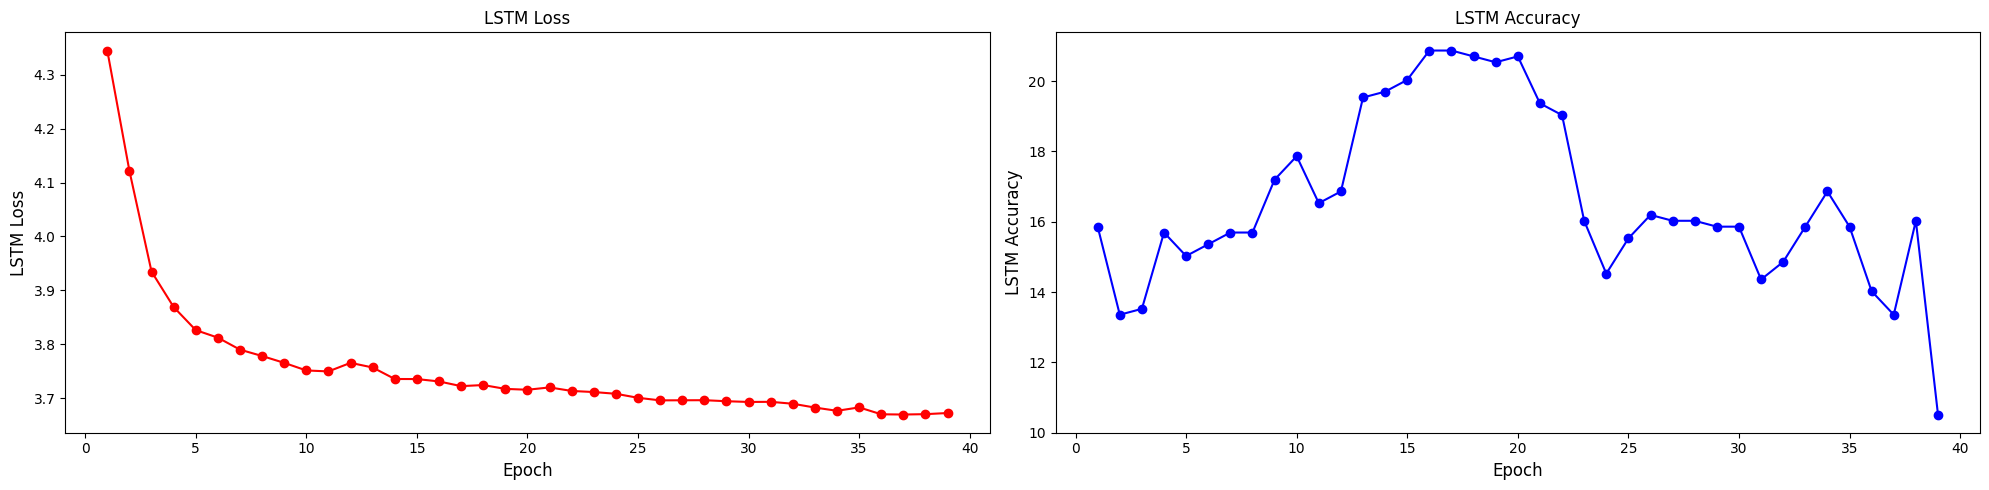

In [ ]:
# Run the Training and Evaluation
# thrid model => LSTM

model_3 = LSTM(hidden_size=128, num_layers=2, dropout=0.2).to(device)
opt = optim.Adam(model_3.parameters(), lr = 1e-3)
early_stopping = EarlyStopping(patience = 3, verbose = True, path='LSTM.pt')

# Plot
fig = plt.figure(figsize=(20,5))
line1, line2 = plt.plot([],[],[],[])
plt.clf()

# Train the Network
epochs = 50

for t in range(epochs):
    print(f'----- Epoch {t+1} -----')
    train(train_loader, model_3, opt)
    accuracy, loss = test(valid_loader, model_3)

    early_stopping(loss, model_3)

    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
 
    # Add Accuracy & Loss to the Lines
    line1.set_xdata(np.append(line1.get_xdata(), t+1))
    line1.set_ydata(np.append(line1.get_ydata(), loss))
    line2.set_ydata(np.append(line2.get_ydata(), accuracy))

fig.add_subplot(1,2,1)
plt.title('LSTM Loss')
plt.plot(line1.get_xdata(), line1.get_ydata(), color='red')
plt.plot(line1.get_xdata(), line1.get_ydata(), 'o', color='red')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('LSTM Loss', fontsize=12)
fig.add_subplot(1,2,2)
plt.title('LSTM Accuracy')
plt.plot(line1.get_xdata(), line2.get_ydata(), color='blue')
plt.plot(line1.get_xdata(), line2.get_ydata(), 'o', color='blue')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('LSTM Accuracy', fontsize=12)
 
plt.tight_layout()
plt.autoscale()
plt.show()

In [ ]:
# # https://coding-yoon.tistory.com/190
# # https://github.com/kyungyunlee/sampleCNN-pytorch/blob/master/model.py

# class CNN(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.num_frame = 30
#     self.n_mels = 40
    
#     self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
#     self.db_converter = torchaudio.transforms.AmplitudeToDB()

    
#     self.nn_conv1d = nn.Sequential(
#                     nn.Conv1d(in_channels=self.n_mels*self.num_frame, out_channels=32, kernel_size=3),             
#                     nn.ReLU(),
#                     nn.MaxPool2d(kernel_size=2), 

#                     nn.Conv1d(in_channels=32, out_channels=128, kernel_size=3),            
#                     nn.ReLU(),
#                     nn.MaxPool2d(kernel_size=2),   
                                                
#                     nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),          
#                     nn.ReLU(),
#                     nn.MaxPool2d(kernel_size=2)
#     )

#     self.nn_layer = nn.Sequential(
#                     nn.Linear(256, 128),                                             
#                     nn.ReLU(),
#                     nn.Dropout(0.2),

#                     nn.Linear(128, 64),                                             
#                     nn.ReLU(),
#                     nn.Dropout(0.2),

#                     nn.Linear(64, 10)
#     )                               
    
    
#   def forward(self, x):
#     spec = self.mel_spec_converter(x)
#     db_spec = self.db_converter(spec)
#     sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
#     sliced_spec = sliced_spec.reshape(x.shape[0], -1) # -1은 남는 디멘션을 자동으로 계산. 전체 element가 3200이고 0번째 dim 8이면 남은 1번째 디멘션은 자동으로 400

#     out = sliced_spec.view(x.shape[0], -1, 1)

#     out = self.nn_conv1d(out)

#     out = out.view(x.shape[0], out.size(1) * out.size(2))

#     out = self.nn_layer(out)
    
#     return torch.softmax(out, dim=-1)

In [ ]:
# # Run the Training and Evaluation
# # fourth model => MLP

# model_4 = CNN().to(device)
# opt = optim.Adam(model_4.parameters(), lr = 1e-3)
# early_stopping = EarlyStopping(patience = 3, verbose = True, path='CNN.pt')

# # Plot
# fig = plt.figure(figsize=(20,5))
# line1, line2 = plt.plot([],[],[],[])
# plt.clf()

# # Train the Network
# epochs = 50

# for t in range(epochs):
#     print(f'----- Epoch {t+1} -----')
#     train(train_loader, model_4, opt)
#     accuracy, loss = test(valid_loader, model_4)

#     early_stopping(loss, model_4)

#     if early_stopping.early_stop: # 조건 만족 시 조기 종료
#         break
 
#     # Add Accuracy & Loss to the Lines
#     line1.set_xdata(np.append(line1.get_xdata(), t+1))
#     line1.set_ydata(np.append(line1.get_ydata(), loss))
#     line2.set_ydata(np.append(line2.get_ydata(), accuracy))

# fig.add_subplot(1,2,1)
# plt.title('CNN Loss')
# plt.plot(line1.get_xdata(), line1.get_ydata(), color='red')
# plt.plot(line1.get_xdata(), line1.get_ydata(), 'o', color='red')
# plt.xlabel('Epoch', fontsize=12); plt.ylabel('CNN Loss', fontsize=12)
# fig.add_subplot(1,2,2)
# plt.title('CNN Accuracy')
# plt.plot(line1.get_xdata(), line2.get_ydata(), color='blue')
# plt.plot(line1.get_xdata(), line2.get_ydata(), 'o', color='blue')
# plt.xlabel('Epoch', fontsize=12); plt.ylabel('CNN Accuracy', fontsize=12)
 
# plt.tight_layout()
# plt.autoscale()
# plt.show()

In [ ]:
# num = len(testset)
# correct = 0
# fail = 0

# for i in range(num) :
#     genre_names = testset.genre_names

#     data = testset[i][0]
#     data = data.reshape(1, data.shape[0])

#     # 원래 장르
#     label = testset[i][1]
#     origin_genre = genre_names[label]

#     # 예측 장르
#     pred = model_2(data)
#     pred_label = torch.argmax(pred)
#     pred_genre = genre_names[pred_label]

#     print('-------------------')
#     print(f'원래 장르 :{origin_genre}')
#     print(f'예측 장르 :{pred_genre}')
    
#     if origin_genre == pred_genre :
#         print('\nCorrect!!!')
#         correct += 1
#     else :
#         print('\nFail...')
        
# print('-------------------\n')
# print(f'맞춘 갯수 :{correct}/{num}\n정확도 :{((correct/num)*100):>0.1f}%')

-------------------
blues
metal

Fail...
-------------------
blues
rock

Fail...
-------------------
blues
country

Fail...
-------------------
blues
reggae

Fail...
-------------------
blues
reggae

Fail...
-------------------
blues
jazz

Fail...
-------------------
blues
classical

Fail...
-------------------
blues
blues

Correct!!!
-------------------
blues
hiphop

Fail...
-------------------
blues
jazz

Fail...
-------------------
blues
disco

Fail...
-------------------
blues
blues

Correct!!!
-------------------
blues
blues

Correct!!!
-------------------
blues
blues

Correct!!!
-------------------
blues
blues

Correct!!!
-------------------
blues
blues

Correct!!!
-------------------
blues
jazz

Fail...
-------------------
blues
jazz

Fail...
-------------------
blues
classical

Fail...
-------------------
blues
blues

Correct!!!
-------------------
blues
country

Fail...
-------------------
blues
blues

Correct!!!
-------------------
blues
country

Fail...
-------------------
b

In [ ]:
def predict(dataset, model) :
    num = len(dataset)
    correct = 0

    for i in range(num) :
        genre_names = dataset.genre_names

        data = dataset[i][0]
        data = data.reshape(1, data.shape[0])

        # 원래 장르
        label = dataset[i][1]
        origin_genre = genre_names[label]

        # 예측 장르
        pred = model(data)
        pred_label = torch.argmax(pred)
        pred_genre = genre_names[pred_label]
        
        if origin_genre == pred_genre :
            correct += 1
            
    print(f'맞춘 갯수 :{correct}/{num}\n정확도 :{((correct/num)*100):>0.1f}%')

In [ ]:
best_model = MLP()
best_model.load_state_dict(torch.load('MLP_1.pt'))
best_model.eval

<bound method Module.eval of MLP(
  (mel_spec_converter): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (db_converter): AmplitudeToDB()
  (nn_layer): Sequential(
    (0): Linear(in_features=1200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)>

In [ ]:
predict(testset, best_model)

맞춘 갯수 :78/200
정확도 :39.0%


In [ ]:
predict(trainset, best_model)

맞춘 갯수 :573/599
정확도 :95.7%


In [ ]:
predict(validset, best_model)

맞춘 갯수 :71/200
정확도 :35.5%


In [19]:
def play_music(data) :  # .wav 파일만 가능
    audio, sr = torchaudio.load(data)
    
    return ipd.Audio(audio, rate=sr)

In [ ]:
def music_genre_predict(data, model):   # .wav 파일만 가능
    genre_names = trainset.genre_names

    audio, _ = torchaudio.load(data)

    output = model(audio)[0]
    
    genre_num = torch.argmax(output)
    genre = genre_names[genre_num]
 
    return  genre

In [21]:
for_predict_1 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/사건의 지평선 - 윤하 (YOUNHA) (30s).wav' # metal, rock
for_predict_2 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/Peaches - Justin Bieber (30s).wav' # pop, r&b
for_predict_3 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/D.I.S.C.O (Feat. TOP) - 엄정화 (30s).wav' # dance, disco
for_predict_4 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/새삥 (Prod. ZICO) (Feat 호미들) - 지코 (ZICO) (30s).wav' # rap, hiphop
for_predict_5 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/Santa Tell Me - Ariana Grande (30s).wav' # pop
for_predict_6 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/10000 Hours - Dan + Shay, Justin Bieber (30s).wav' # country
for_predict_7 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/DREAMERS - 정국 (30s).wav' # pop
for_predict_8 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/Galway Girl - Ed Sheeran (30s).wav' # pop 이라고 나와있지만 들었을 때는 country 같다.
for_predict_9 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/TOMBOY - (여자)아이들 (30s).wav' # rock, metal
for_predict_10 = '../데이터/GTZAN Dataset - Music Genre Classification/for predict/30s wav/Snowman - Sia (30s).wav' # pop

In [ ]:
print("* MLP Model Predition Result *\n")
print("'사건의 지평선 - 윤하 (YOUNHA)' 예측 장르 :", music_genre_predict(for_predict_1, best_model)) # 본 장르 : metal, rock
print("\n--------------------------------------------------------------\n")
print("'Peaches - Justin Bieber' 예측 장르 :", music_genre_predict(for_predict_2, best_model)) # 본 장르 : pop, r&b
print("\n--------------------------------------------------------------\n")
print("'D.I.S.C.O (Feat. TOP) - 엄정화' 예측 장르 :", music_genre_predict(for_predict_3, best_model)) # 본 장르 : dance, disco
print("\n--------------------------------------------------------------\n")
print("'새삥 (Prod. ZICO) (Feat 호미들) - 지코 (ZICO)' 예측 장르 :", music_genre_predict(for_predict_4, best_model)) # 본 장르 : rap, hiphop
print("\n--------------------------------------------------------------\n")
print("'Santa Tell Me - Ariana Grande' 예측 장르 :", music_genre_predict(for_predict_5, best_model)) # 본 장르 : pop
print("\n--------------------------------------------------------------\n")
print("'10000 Hours - Dan + Shay, Justin Bieber' 예측 장르 :", music_genre_predict(for_predict_6, best_model)) # 본 장르 : country
print("\n--------------------------------------------------------------\n")
print("'DREAMERS - 정국' 예측 장르 :", music_genre_predict(for_predict_7, best_model)) # 본 장르 : pop
print("\n--------------------------------------------------------------\n")
print("'Galway Girl - Ed Sheeran' 예측 장르 :", music_genre_predict(for_predict_8, best_model)) # 본 장르 : pop 이라고 나와있지만 들었을 때는 country 같다.
print("\n--------------------------------------------------------------\n")
print("'TOMBOY - (여자)아이들' 예측 장르 :", music_genre_predict(for_predict_9, best_model)) # 본 장르 : rock, metal
print("\n--------------------------------------------------------------\n")
print("'Snowman - Sia' 예측 장르 :", music_genre_predict(for_predict_10, best_model)) # 본 장르 : pop

* MLP Model Predition Result *

'사건의 지평선 - 윤하 (YOUNHA)' 예측 장르 : metal

--------------------------------------------------------------

'Peaches - Justin Bieber' 예측 장르 : rock

--------------------------------------------------------------

'D.I.S.C.O (Feat. TOP) - 엄정화' 예측 장르 : metal

--------------------------------------------------------------

'새삥 (Prod. ZICO) (Feat 호미들) - 지코 (ZICO)' 예측 장르 : hiphop

--------------------------------------------------------------

'Santa Tell Me - Ariana Grande' 예측 장르 : rock

--------------------------------------------------------------

'10000 Hours - Dan + Shay, Justin Bieber' 예측 장르 : rock

--------------------------------------------------------------

'DREAMERS - 정국' 예측 장르 : disco

--------------------------------------------------------------

'Galway Girl - Ed Sheeran' 예측 장르 : rock

--------------------------------------------------------------

'TOMBOY - (여자)아이들' 예측 장르 : rock

--------------------------------------------------------------

'Sno